# Import modules

In [ ]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from scipy.sparse import diags
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seeds
random.seed(1)
np.random.seed(1)

torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ativate GPU if needed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install neuraloperator
!pip install torch_harmonics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 780.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
#Get latex commands
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
plt.rcParams['text.usetex'] = False

# Define initial parameters

In [ ]:
#Space grid (same for all dimension), nleft bound, right bound, and number of points
lb = 0
rb = 1
n_x = 64

#Define data points number
m = 200

#Data oscillations (how many sin/cos waves to superpose) and initial coeficient bound
c_1 = 20
k = 4

#Number of output times
t_k = 10

#Boundary conditions type (inactive for now - Dirichlet zero boundaries in place)
Boundary_cond = 'Dirichlet'
#Boundary conditions if Dirichlet (inactive for now - Dirichlet zero boundaries in place)
T_0 = 0
T_1 = 0

#Coefficients cap
max_a = 2.5
#Epsilon value (for coefficient and model parameter caps)
epsilon = 0.0001

#Maximum coarsening factor for experiments
coars_max = 8

#Optimization parameters: regularization, batch size, train-val-test percentage split
batch_s = 16
train_size = 0.75
val_size = 0.125

#Example soltution to plot
test_data = 19

# Define mesh, particular to the heat equation: $dt \sim dx^2$

We pick $n_t = 2\cdot dimension \cdot max(a(x,y))\cdot n_x^2$ and this will ensure stability of the Finite Differences algorithm since $\frac{a(x,y)d_t}{d_x^2} \leq \frac{max(a(x,y))d_t}{d_x^2} = \frac{1}{2\cdot dimension}$

In [ ]:
#Define space and time mesh
n_t = int(4*max_a*n_x*n_x)

xmesh = torch.linspace(lb, rb, n_x).to(device)
tmesh = torch.linspace(0, 1, n_t).to(device)

dx = xmesh[1]-xmesh[0]
dt = tmesh[1]-tmesh[0]

# Define random initial conditions

Made up of a superposition of k (hyperparameter defined above) sin waves




In [ ]:
# Random initial conditions made up of a combination of sin(pi*k*x) functions - decaying as 1/k
x1, x2 = np.meshgrid(xmesh.cpu(), xmesh.cpu())
def sin_xy(x,y,i,j):
  return np.sin(np.pi*i*x)*np.sin(np.pi*j*y)

coef_vector = torch.ones((k,k)).to(device)
for i in range(k):
  for j in range(k):
    if ((i<=1) and (j<=1)):
      coef_vector[i][j] = 1
    else:
      coef_vector[i][j] = 0

def initial_cond_dirichlet(x_mesh,k):
  coefs_rand = (torch.rand((k,k))-0.5).to(device)
  coefs_actual = coef_vector*coefs_rand
  func=torch.zeros((len(x_mesh),len(x_mesh))).to(device)
  for i in range(1, k+1):
    for j in range(1,k+1):
      func+=(coefs_actual[i-1][j-1]*torch.tensor(sin_xy(x1,x2,i,j)).to(device))

  max = torch.max(func)
  min = torch.min(func)
  func = 2*func/(max-min)
  coefs_actual = 2*coefs_actual/(max-min)
  return func, coefs_actual

## Define the coeficients for the equatiion to model: $u_t = a(x,y)(u_{xx}+u_{yy})$

Capped between max_a and zero to ensure stability (hyperparameters defined above). The epsilon value just ensures the caps are not attained so that the model can learn the parameters exactly





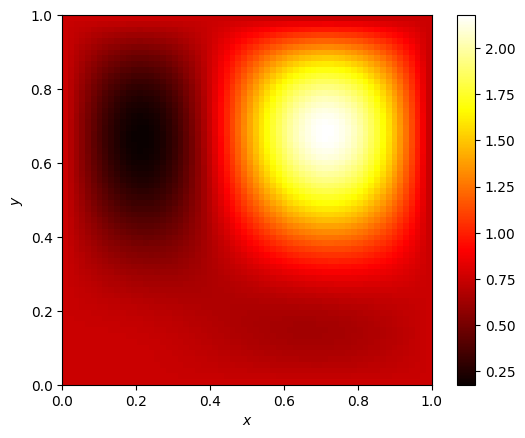

In [ ]:
#Define 2D grid and return evaluated coefficient values
a_xy = initial_cond_dirichlet(xmesh,k)[0].to(device)+0.75
a_xy = torch.maximum(torch.minimum(a_xy, torch.tensor(max_a - epsilon)), torch.tensor(epsilon))

#Visualize the coefficients (also an example of initial conditions)
plt.imshow(a_xy.cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [ ]:
#Construct the data of initial conditions
coefficients = torch.zeros((m, k, k)).to(device)
initial_conditions = torch.zeros(m, n_x, n_x).to(device)
for j in range(m):
  function, coefs = initial_cond_dirichlet(xmesh, k)
  initial_conditions[j]= function
  coefficients[j] = coefs

# Fully resolved finite difference method, later coarsened
- first run the fully resolved FD method
- then averaged down to coarse mesh
- average in space x-factor adjacent grid points
- sample in time, (the t-factor time step)


In [ ]:
#Define inputs and outputs of neural net which are PDE intitial condition and averaged solution at t=1,..,t_k respectively

#Maximum time value to generate data for
t_max = coars_max**2*t_k+1
solutions_exact = torch.zeros((1, t_max, n_x, n_x)).to(device)

filter = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]]).float().to(device)
one_filter = torch.tensor([[1]]).float().to(device)
#Loop over all initial conditions (data points)
for j in range(m):
  #Create FD solution with initial condition
  sol = torch.zeros((t_max, n_x, n_x)).to(device)
  sol[0]=initial_conditions[j]

  #Solve forward in time (full grid) using finite differences
  for i in range(1, t_max):
    # Performs convolution corresponding to numerical FD step
    convolution_no_pad = F.conv2d(sol[i-1].unsqueeze(0), filter.unsqueeze(0).unsqueeze(0), padding = 0)/(dx**2)
    # Adds boundary zero condition (hacky way to add ZERO boundary condition)
    convolution_with_zero_pad = F.conv2d(convolution_no_pad, one_filter.unsqueeze(0).unsqueeze(0), padding = 1).squeeze(0)
    # time step
    sol[i] = sol[i-1] + dt*(convolution_with_zero_pad)*a_xy

  #Add to solutions tensor
  solutions_exact = torch.cat((solutions_exact, sol.view(1, t_max, n_x, n_x)), 0)

In [ ]:
#Construct the OOD data from a different spectrum
OOD_spec = torch.ones((k,k)).to(device)
for i in range(k):
  for j in range(k):
    if ((i>=2) and (j>=2)):
      OOD_spec[i][j] = 1
    else:
      # OOD_spec[i][j] = 1/(np.sqrt((3-i)**2+(3-j)**2))
      OOD_spec[i][j] = 0

def initial_cond_OOD(x_mesh,k):
  coefs_rand = (torch.rand((k,k))-0.5).to(device)
  coefs_actual = OOD_spec*coefs_rand
  func=torch.zeros((len(x_mesh),len(x_mesh))).to(device)
  for i in range(1, k+1):
    for j in range(1,k+1):
      func+=(coefs_actual[i-1][j-1]*torch.tensor(sin_xy(x1,x2,i,j)).to(device))

  max = torch.max(func)
  min = torch.min(func)
  func = 2*func/(max-min)
  coefs_actual = 2*coefs_actual/(max-min)
  return func, coefs_actual

coefficients_OOD = torch.zeros((50, k, k)).to(device)
initial_conditions_OOD = torch.zeros(50, n_x, n_x).to(device)
for j in range(50):
  function, coefs = initial_cond_OOD(xmesh, k)
  initial_conditions_OOD[j]= function
  coefficients_OOD[j] = coefs

In [ ]:
#Define an out of distribution data point (i.e. 2 oscillations instead of 4)
solutions_exact_OOD = torch.zeros((1,t_max,n_x,n_x)).to(device)

for j in range(50):
  sol = torch.zeros((t_max,n_x,n_x)).to(device)
  sol[0]=initial_conditions_OOD[j]

  for i in range(1, t_max):
    convolution_no_pad = F.conv2d(sol[i-1].unsqueeze(0), filter.unsqueeze(0).unsqueeze(0), padding = 0)/(dx**2)
    convolution_with_zero_pad = F.conv2d(convolution_no_pad, one_filter.unsqueeze(0).unsqueeze(0), padding = 1).squeeze(0)
    sol[i] = sol[i-1] + dt*(convolution_with_zero_pad)*a_xy

  solutions_exact_OOD = torch.cat((solutions_exact_OOD, sol.view(1,t_max,n_x,n_x)), 0)

##Coarsening:

Coarsen the space grid by x_factor defined below and sample solutions at the t_factor which corresponds to $x\_factor^2$ for stability

In [ ]:
#Factor by which to coarsen x-grid and new number of grid points (for easier to read code later)
x_factor = 4
n_x_new = int(n_x/x_factor)
#Corresponding t_factor
t_factor = x_factor**2

In [ ]:
from traitlets.config.application import T
#Define the coarsening function using pooling layers and ensuring the Dirichlet zero boundary conditions
def coarsen(sol, n_x, x_factor):
  sol_avg = torch.zeros((t_k, n_x_new, n_x_new)).to(device)

  #For each output average pool the values and then add the boundary conditions
  for t in range(t_k):
    sol_avg[t] = F.avg_pool2d(sol[t_factor*(t+1)].unsqueeze(0),x_factor)
    for i in range(n_x_new):
      sol_avg[t][i][0] = 0
      sol_avg[t][i][-1] = 0
    sol_avg[t][0] = torch.zeros(n_x_new)
    sol_avg[t][-1] = torch.zeros(n_x_new)

  #For the iput average pool the values and then add the boundary conditions
  inp_avg = F.avg_pool2d(sol[0].unsqueeze(0),x_factor)
  for i in range(n_x_new):
    inp_avg[0][i][0] = 0
    inp_avg[0][i][-1] = 0
  inp_avg[0][0] = torch.zeros(n_x_new)
  inp_avg[0][-1] = torch.zeros(n_x_new)

  return inp_avg, sol_avg


In [ ]:
#Define the inputs and outputs of the model (inputs are the initial conditons coarsened and
#outputs are the outputs at the sampled times coarsened in space too)
inputs = torch.zeros((1, n_x_new, n_x_new)).to(device)
outputs = torch.zeros((1, t_k, n_x_new, n_x_new)).to(device)

for j in range(1, m+1):
  # Coarsen the solution
  inp_avg, sol_avg = coarsen(solutions_exact[j], n_x, x_factor)

  #Conactenate our input-output pair to the respective tensors
  inputs = torch.cat((inputs, inp_avg.view(1, n_x_new, n_x_new)), 0)
  outputs = torch.cat((outputs, sol_avg.view(1, t_k, n_x_new, n_x_new)),0)

# Format data into pytorch data_loaders

In [ ]:
# Add an extra dimension to inputs for mathematical stability of matrices
inputs = torch.unsqueeze(inputs,1)

In [ ]:
# Chek input and output sizes
print(inputs.size())
print(outputs.size())

torch.Size([201, 1, 16, 16])
torch.Size([201, 10, 16, 16])


In [ ]:
# Format data into datsets and then load them as dataloaders with batch size 16 (this can change)
Data_heat = TensorDataset(inputs, outputs)

Data_heat_train, Data_heat_val, Data_heat_test = torch.utils.data.random_split(Data_heat,
 [int(m*train_size)+1, int(m*val_size), m-int(m*train_size)-int(m*val_size)])

Heat_DataLoader_train = DataLoader(Data_heat_train, batch_size=batch_s, shuffle=True)
Heat_DataLoader_val = DataLoader(Data_heat_val, batch_size=batch_s, shuffle=True)
Heat_DataLoader_test = DataLoader(Data_heat_test, batch_size=batch_s, shuffle=True)

In [ ]:
#Define inputs and outputs
inputs_OOD = torch.zeros((1,n_x_new, n_x_new)).to(device)
outputs_OOD = torch.zeros((1,t_k,n_x_new, n_x_new)).to(device)

for j in range(50):
  # Coarsen the solution
  inp_avg, sol_avg = coarsen(solutions_exact_OOD[j], n_x, x_factor)

  #Conactenate our input-output pair to the respective tensors
  inputs_OOD = torch.cat((inputs_OOD, inp_avg.view(1,n_x_new,n_x_new)), 0)
  outputs_OOD = torch.cat((outputs_OOD, sol_avg.view(1,t_k,n_x_new,n_x_new)),0)

inputs_OOD = torch.unsqueeze(inputs_OOD,1)

In [ ]:
# Format data into datsets and then load them as dataloaders
Data_heat_OOD = TensorDataset(inputs_OOD, outputs_OOD)
Heat_DataLoader_OOD = DataLoader(Data_heat_OOD, batch_size=batch_s, shuffle=True)

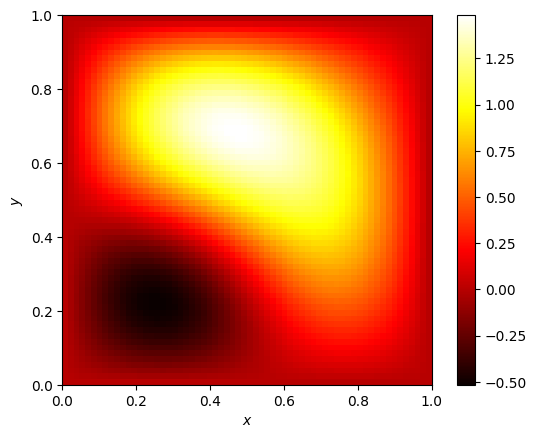

In [ ]:
#Subgrid example for Thesis
fine = solutions_exact[77]
coarse, _ = coarsen(fine, n_x, x_factor)

#Visualize the coefficients (also an example of initial conditions)
plt.imshow(fine.cpu()[0], cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

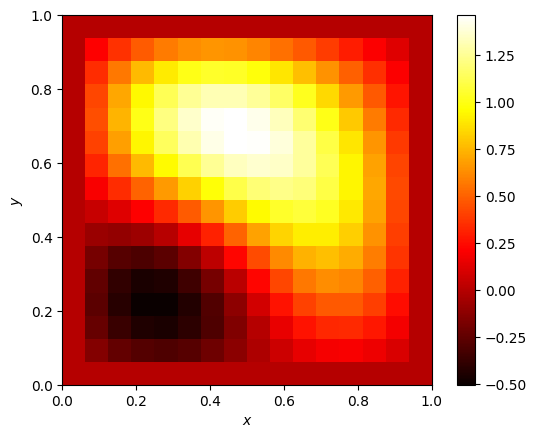

In [ ]:
#Thesis - coarsening
plt.imshow(coarse.cpu()[0], cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [ ]:
from numpy.lib.twodim_base import vander
from numpy.lib.shape_base import apply_over_axes
# Define the Coarsened FD method as a neural net
class IndividualLayer_PDE(nn.Module):
  """This class implements an individual layer of the coarsened grid FD method"""

  def __init__(self, grid_size):
    """
      grid_size: int
        size of coarsened grid
    """
    super(IndividualLayer_PDE, self).__init__()

    #Define convolution filter corresponding to the heat equation partial derivatives
    self.filter = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]]).float().to(device)/(dx**2)
    #Define convolution filter of 1 to add the zero boundary condition
    self.one_filter = torch.tensor([[1]]).float().to(device)

    # Initialize parameters randomly in (-0.5, 0.5)
    self.coefs_a = torch.nn.Parameter(2.5*(torch.rand(grid_size, grid_size)-0.5))

  def forward(self, v):
    """
      x: Tensor
        Coarsened inputs at a given time

      Outputs: Returns the predicted coarsened outputs at the next time
    """
    # Bound coeficients between zero and max_a for stability
    a_xy_pred = max_a*torch.sigmoid(self.coefs_a)
    # a_xy_pred = self.coefs_a

    # Implement the FD method on the coarsened grid (to learn parameters through back-propagation) - same as when generating the non-coarsened data
    convolution_no_pad = F.conv2d(v, self.filter.unsqueeze(0).unsqueeze(0), padding = 0)
    convolution_with_zero_pad = F.conv2d(convolution_no_pad, one_filter.unsqueeze(0).unsqueeze(0), padding = 1)
    a_xx_yy = convolution_with_zero_pad*a_xy_pred

    y = v + dt*(a_xx_yy)
    return y

In [ ]:
from math import nextafter
class PDE_Solver(nn.Module):
  """This class implements the Full Coarsened FD method"""

  def __init__(self, grid_size):
    """
      grid_size: int
        size of coarsened grid
    """
    super(PDE_Solver, self).__init__()

    # Call the individual layer class defined previously
    self.layer = IndividualLayer_PDE(grid_size)

  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs to the network at time 0

      Outputs: Returns the coarsened outputs at the next t_k times
    """

    # Call the individual layer (FD method) t_k times to generate the next t_k time predictions in the coarsened grid
    # and concatenate the new value to the output tensor
    prev = x
    next = self.layer(prev)
    y = next
    prev = next

    for i in range(t_k-1):
      next = self.layer(prev)
      y = torch.cat((y,next),1)
      prev = next

    return y

# Define the Training and Validation for the model

In [ ]:
# Define one training epoch through the train and valudate functions
# Each call to train and validate runs a training and validation epoch
# This is generic code that serves to train and validate any ML model with Pytorch
def train(model, dataloader, optimizer, criterion):
    train_loss = 0.
    model.train()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)
        # print(source.shape)
        # print(target.shape)

        optimizer.zero_grad()
        output = model(source)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end = time.time()
    train_loss /= len(dataloader)
    train_time = end - start
    return train_loss, train_time

def validate(model, dataloader, criterion):
    val_loss = 0.
    model.eval()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        output = model(source)
        loss = criterion(output, target)
        val_loss += loss.item()

    end = time.time()
    val_loss /= len(dataloader)
    val_time = end - start
    return val_loss, val_time

# Run it / Train the Model and plot learning dynamics


In [ ]:
# Define the model as the PDE_Solver class and feed in the coarsed grid size
# Optimize with Adam and our loss is the L_2 loss
model = PDE_Solver(n_x_new).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = 0)
criterion = torch.nn.MSELoss()

# Collect the results of the training and validation
results = {
    "train_losses": [],
    "train_times":  [],
    "valid_losses": [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_time":    0.
}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    n_epochs = 1000

    for epoch in range(n_epochs):
        train_loss, train_time = train(model, Heat_DataLoader_train, optimizer, criterion)
        valid_loss, valid_time = validate(model, Heat_DataLoader_val, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_times"].append(valid_time)

    test_loss, test_time = validate(model, Heat_DataLoader_test, criterion)
    print(f"== Test Loss: {test_loss} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_time"] = test_time

Epoch: 0
Train Loss: 0.0012104571564123035 | Train Time: 0.574
Valid Loss: 0.001080603280570358 | Valid Time: 0.007
Epoch: 1
Train Loss: 0.0012087229872122407 | Train Time: 0.052
Valid Loss: 0.001110951998271048 | Valid Time: 0.005
Epoch: 2
Train Loss: 0.0011848622583784164 | Train Time: 0.051
Valid Loss: 0.0010934728779830039 | Valid Time: 0.005
Epoch: 3
Train Loss: 0.0011747141019441188 | Train Time: 0.059
Valid Loss: 0.0010567097924649715 | Valid Time: 0.005
Epoch: 4
Train Loss: 0.0011570532340556383 | Train Time: 0.055
Valid Loss: 0.0010622671688906848 | Valid Time: 0.005
Epoch: 5
Train Loss: 0.0011343912803567946 | Train Time: 0.054
Valid Loss: 0.0010297296685166657 | Valid Time: 0.004
Epoch: 6
Train Loss: 0.0011313612223602832 | Train Time: 0.052
Valid Loss: 0.0010127014247700572 | Valid Time: 0.005
Epoch: 7
Train Loss: 0.0011097626411356032 | Train Time: 0.049
Valid Loss: 0.0010123309621121734 | Valid Time: 0.005
Epoch: 8
Train Loss: 0.0010997800854966044 | Train Time: 0.061
Val

Text(0, 0.5, 'MSE')

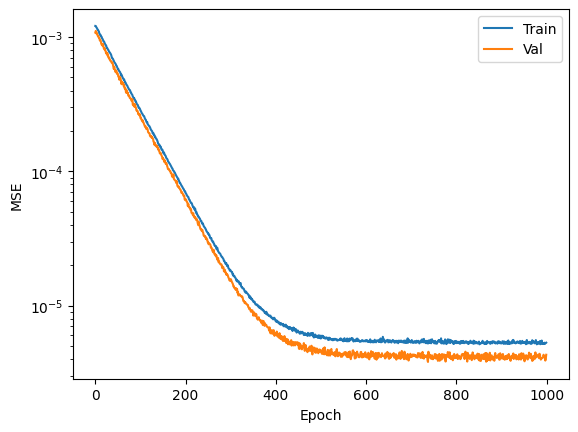

In [ ]:
# Plot the training and validation losses
plt.plot(results["train_losses"])
plt.plot(results["valid_losses"])
plt.legend(['Train', 'Val'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
# Print the learned parameters and collect the coeafficients found by the model
results_coefs_a = np.zeros((n_x_new,n_x_new))
for i, param in enumerate(model.parameters()):
  print(param)
  if i ==0:
    for j1 in range(n_x_new):
      for j2 in range(n_x_new):
        results_coefs_a[j1][j2]=2*max_a*torch.tanh(param[j1][j2])

Parameter containing:
tensor([[ 0.4741,  0.4231, -1.0720, -1.1237,  0.1977, -0.2808, -0.5598, -0.5431,
         -0.8351,  0.5364, -1.0139, -0.6269,  0.6582,  0.5277, -0.4550, -1.1958],
        [ 0.6043, -2.2490, -1.7751, -1.7933, -1.8264, -1.8820, -1.9765, -2.1145,
         -2.1679, -2.0786, -2.0006, -1.9531, -1.9144, -1.8756, -2.3200, -0.2648],
        [ 0.5733, -1.7877, -0.8544, -0.8744, -0.8959, -0.9232, -0.9548, -0.9932,
         -1.0259, -1.0408, -1.0490, -1.0421, -1.0180, -0.9721, -1.8440, -0.9840],
        [ 0.3548, -1.8345, -0.9170, -0.9487, -0.9694, -0.9844, -0.9927, -0.9938,
         -0.9872, -0.9764, -0.9622, -0.9444, -0.9244, -0.8946, -1.8084,  1.0297],
        [-0.0437, -1.9169, -1.0192, -1.0656, -1.0745, -1.0522, -1.0032, -0.9346,
         -0.8535, -0.7848, -0.7356, -0.7070, -0.7022, -0.7106, -1.7327, -0.0062],
        [ 1.1823, -2.0464, -1.1697, -1.2363, -1.2214, -1.1347, -0.9967, -0.8291,
         -0.6478, -0.5062, -0.4141, -0.3733, -0.3898, -0.4491, -1.6395,  0.2595],


In [ ]:
# Plot an example solution
sol_model_act = solutions_exact[test_data]

#Sample our solution to t_k time steps
sol_model_act_avg = torch.zeros((t_k, n_x, n_x)).to(device)
for i in range (t_k):
  sol_model_act_avg[i] = sol_model_act[t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input
sol_model_pred = model(inputs[test_data].unsqueeze(0)).squeeze(0).detach().cpu().numpy()

In [ ]:
import scipy
#Get the averaged mesh values in one dimension (since it is a rectangular grid it is the same in all dimensions)
x_mesh_avg = torch.zeros(n_x_new).to(device)
for i in range(n_x_new):
  x_mesh_avg[i] = torch.mean(xmesh[x_factor*i:x_factor*(i+1)])
x_mesh_avg[0]=0
x_mesh_avg[-1]=1

#Interpolate our solution to the fine grid
test_time = 0
interp2d_sol = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                         sol_model_pred[test_time], bounds_error=False, fill_value=None)
interpolated_sol = interp2d_sol((x2, x1))

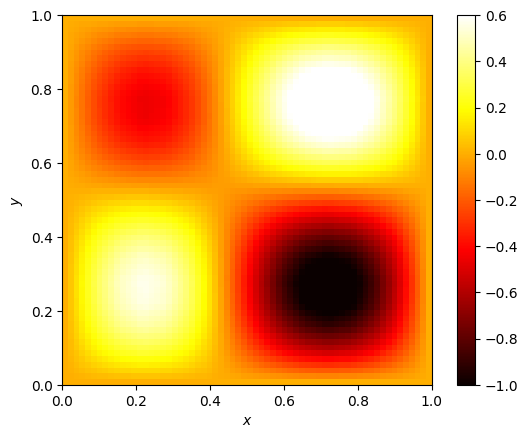

In [ ]:
#Plot our solutions to compare - modelled solution at first predicted time
plt.imshow(interpolated_sol, cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

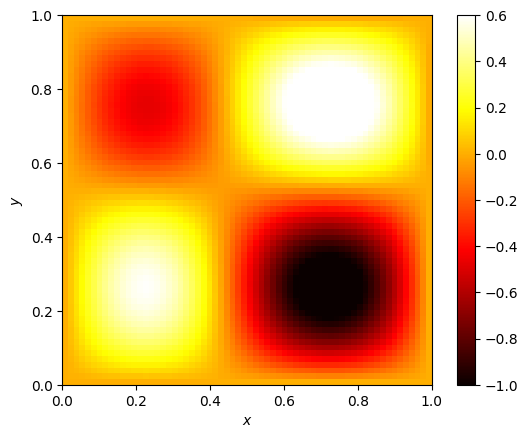

In [ ]:
#Plot our solutions to compare - actual solution at first predicted time
plt.imshow(sol_model_act_avg[test_time].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
sol_model_act_avg[test_time]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  6.2863e-03,  1.2496e-02,  ..., -1.9947e-02,
         -1.0016e-02,  1.7948e-08],
        [ 0.0000e+00,  1.2514e-02,  2.4875e-02,  ..., -3.9715e-02,
         -1.9941e-02,  3.5732e-08],
        ...,
        [ 0.0000e+00, -1.0467e-02, -2.0817e-02,  ...,  3.1120e-02,
          1.5636e-02, -2.8129e-08],
        [ 0.0000e+00, -5.2605e-03, -1.0461e-02,  ...,  1.5654e-02,
          7.8640e-03, -1.4142e-08],
        [ 0.0000e+00,  9.4776e-09,  1.8844e-08,  ..., -2.8171e-08,
         -1.4147e-08,  2.4838e-14]], device='cuda:0')

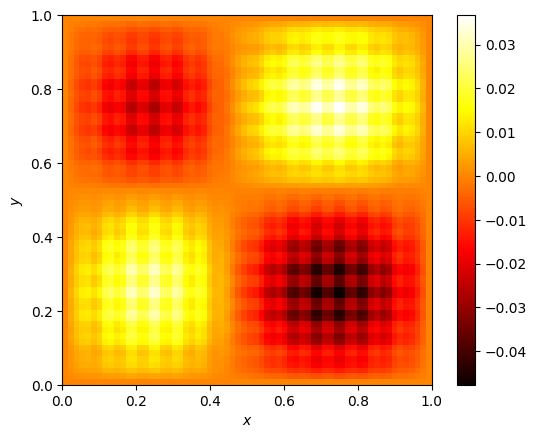

In [ ]:
#Plot our solutions to compare - difference in solutions at first predicted time
plt.imshow(sol_model_act_avg[test_time].cpu()-interpolated_sol, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
inputs[0].shape

torch.Size([1, 16, 16])

## FNO

In [ ]:
from neuralop import models
from neuralop import training
import neuralop


model_fno = models.FNO2d(n_modes_height=12, n_modes_width=12, n_modes_depth=12, hidden_channels=16, in_channels=1, out_channels=10).to(device)
optimizer = optim.Adam(model_fno.parameters(), weight_decay = 0)
criterion = torch.nn.MSELoss()

# Collect the results of the training and validation
results = {
    "train_losses": [],
    "train_times":  [],
    "valid_losses": [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_time":    0.
}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    n_epochs = 1000

    for epoch in range(n_epochs):
        train_loss, train_time = train(model_fno, Heat_DataLoader_train, optimizer, criterion)
        valid_loss, valid_time = validate(model_fno, Heat_DataLoader_val, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_times"].append(valid_time)

    test_loss, test_time = validate(model_fno, Heat_DataLoader_test, criterion)
    print(f"== Test Loss: {test_loss} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_time"] = test_time

Epoch: 0
Train Loss: 0.21060170978307724 | Train Time: 0.107
Valid Loss: 0.1657634824514389 | Valid Time: 0.009
Epoch: 1
Train Loss: 0.0992148756980896 | Train Time: 0.096
Valid Loss: 0.031102179549634457 | Valid Time: 0.009
Epoch: 2
Train Loss: 0.024387066438794135 | Train Time: 0.105
Valid Loss: 0.014803546480834484 | Valid Time: 0.009
Epoch: 3
Train Loss: 0.012410583533346653 | Train Time: 0.095
Valid Loss: 0.00731620704755187 | Valid Time: 0.009
Epoch: 4
Train Loss: 0.006417235685512423 | Train Time: 0.120
Valid Loss: 0.0032644191524013877 | Valid Time: 0.010
Epoch: 5
Train Loss: 0.003848890424706042 | Train Time: 0.102
Valid Loss: 0.0025322132278233767 | Valid Time: 0.008
Epoch: 6
Train Loss: 0.0027859207591973247 | Train Time: 0.104
Valid Loss: 0.0018987117218784988 | Valid Time: 0.009
Epoch: 7
Train Loss: 0.0022395818145014347 | Train Time: 0.097
Valid Loss: 0.001643966359551996 | Valid Time: 0.009
Epoch: 8
Train Loss: 0.002041120082139969 | Train Time: 0.103
Valid Loss: 0.00153

Text(0, 0.5, 'MSE')

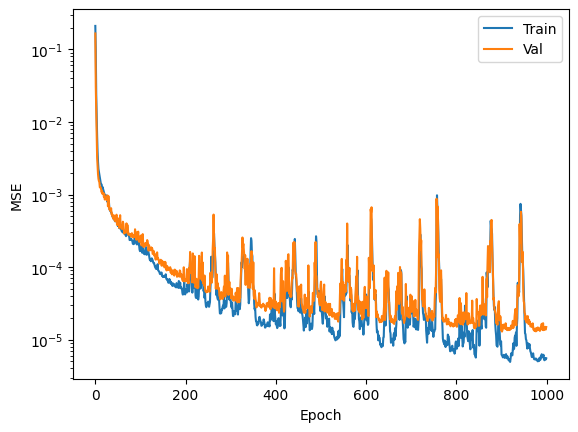

In [ ]:
# Plot the training and validation losses
plt.plot(results["train_losses"])
plt.plot(results["valid_losses"])
plt.legend(['Train', 'Val'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE')

32 hidden channels, 12 modes: 0.0005424386472441256

128 hidden channels, 16 modes: 0.0006063164328224957

16 hidden channels, 12 modes: 0.000515917825396172

best + weight decay: 0.0011384847457520664

# Plot an example of a modelled solution against its fully resolved function

Again interpolating to the fine grid for the modelled solution

In [ ]:
# Plot an example solution
sol_model_act = solutions_exact[test_data]

#Sample our solution to t_k time steps
sol_model_act_avg = torch.zeros((t_k, n_x, n_x)).to(device)
for i in range (t_k):
  sol_model_act_avg[i] = sol_model_act[t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input
sol_model_pred = model_fno(inputs[test_data].unsqueeze(0)).squeeze(0).detach().cpu().numpy()

In [ ]:
#Interpolate our solution to the fine grid
test_time = 0
interp2d_sol = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                         sol_model_pred[test_time], bounds_error=False, fill_value=None)
interpolated_sol = interp2d_sol((x2, x1))

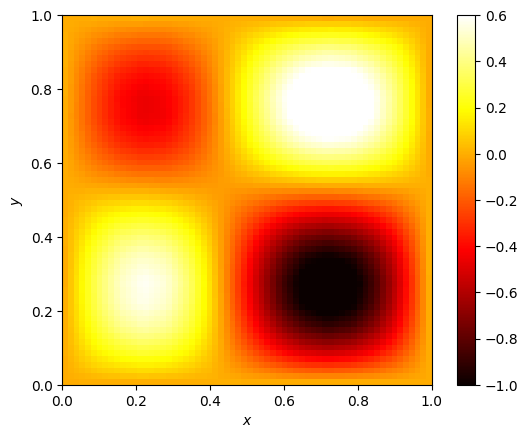

In [ ]:
#Plot our solutions to compare - modelled solution at first predicted time
plt.imshow(interpolated_sol, cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

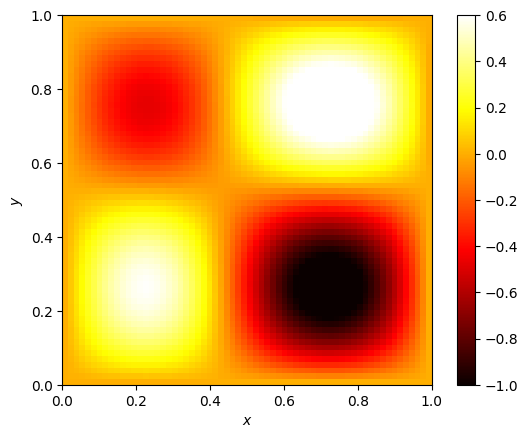

In [ ]:
#Plot our solutions to compare - actual solution at first predicted time
plt.imshow(sol_model_act_avg[test_time].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

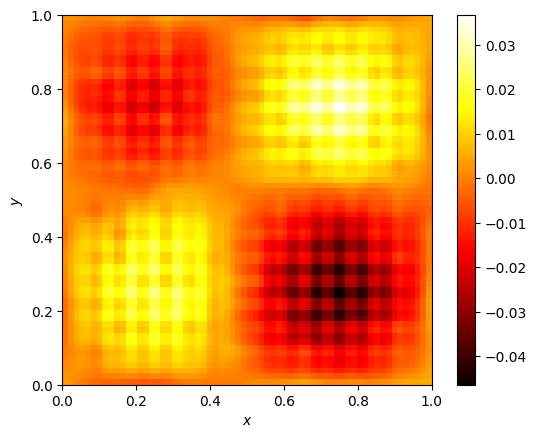

In [ ]:
#Plot our solutions to compare - difference in solutions at first predicted time
plt.imshow(sol_model_act_avg[test_time].cpu()-interpolated_sol, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
import matplotlib

In [ ]:
#Sample our solution to t_k time steps
visual = 9
OOD_avg = torch.zeros((t_k, n_x, n_x)).to(device)
for i in range (t_k):
  OOD_avg[i] = solutions_exact_OOD[visual][t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input for both models
OOD_pred_RCNN = model(inputs_OOD[visual+1].unsqueeze(0)).squeeze(0).detach().cpu().numpy()
OOD_pred_NN = model_fno(inputs_OOD[visual+1].unsqueeze(0)).squeeze(0).detach().cpu().numpy()

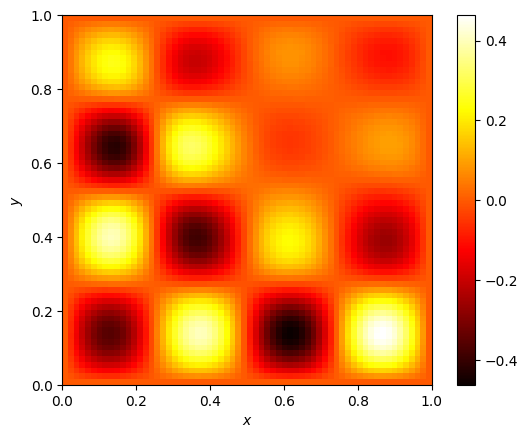

In [ ]:
test_time = 9
#Plot our solutions to compare - actual solution at first predicted time
plt.imshow(OOD_avg[test_time].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

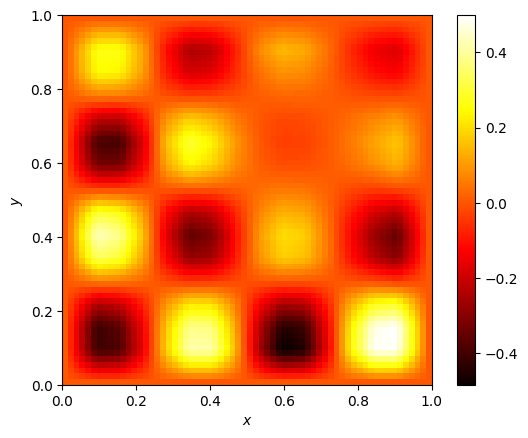

In [ ]:
#Plot our solutions to compare
interp2d_ood = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                         OOD_pred_RCNN[test_time], bounds_error=False, fill_value=None)
interpolated_ood = interp2d_ood((x2, x1))

#Plot our solutions to compare - predicted solution at first predicted time
plt.imshow(interpolated_ood, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

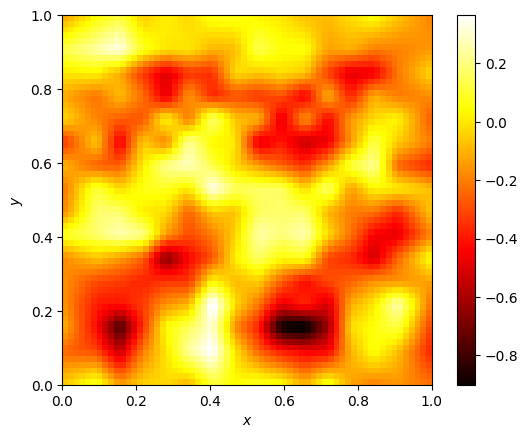

In [ ]:
#Interpolate our solution to the fine grid
interp2d_oodNN = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                          OOD_pred_NN[test_time], bounds_error=False, fill_value=None)
interpolated_oodNN = interp2d_oodNN((x2, x1))

#Plot our solutions to compare - predicted solution at first predicted time
plt.imshow(interpolated_oodNN, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()